# CAUTION!!! DO NOT RUN THIS MODEL DIRECTLY IT HAS BEEN RUN ON GOOGLE COLAB, JUST LOAD IN THE WEIGHTS AND EXECUTE THE LAST CELLS FOR PREDICTION

In [1]:
!nvidia-smi

Fri May 14 12:00:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

# DATA PRE-PROCESSING

In [3]:
!pip install split-folders

In [4]:
!unzip "/content/drive/MyDrive/DATASETS/COVID 19 Major.zip"

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [6]:
import splitfolders
splitfolders.ratio('/content/COVID-19_Radiography_Dataset/Data', output='output', seed=1337, ratio=(.6, 0.3,0.1))

Copying files: 15153 files [00:03, 4958.20 files/s]


In [5]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]  #resnet input size

train_path = '/content/output/train'
valid_path = '/content/output/val'

In [66]:
original_model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 1s 0us/step


In [67]:

# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 1s 0us/step


In [68]:
# don't train existing weights 
for layer in resnet.layers:
    layer.trainable = False

In [12]:
folders = glob('/content/output/train/*')

In [69]:
x = Flatten()(resnet.output)

In [55]:
prediction = Dense(len(folders), activation='softmax')(x)
#len(folders) is 2 since we have 2 classes

# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [70]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [17]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/output/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 9091 images belonging to 3 classes.


In [18]:
test_set = test_datagen.flow_from_directory('/content/output/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4544 images belonging to 3 classes.


## Increase the epochs

In [74]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=5,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
285/285 [==============================] - 159s 558ms/step - loss: 0.2693 - accuracy: 0.8907 - val_loss: 0.2779 - val_accuracy: 0.8856
Epoch 2/5
285/285 [==============================] - 160s 561ms/step - loss: 0.2513 - accuracy: 0.9007 - val_loss: 0.2279 - val_accuracy: 0.9085
Epoch 3/5
285/285 [==============================] - 159s 557ms/step - loss: 0.2435 - accuracy: 0.9034 - val_loss: 0.1970 - val_accuracy: 0.9225
Epoch 4/5
285/285 [==============================] - 158s 555ms/step - loss: 0.2562 - accuracy: 0.8974 - val_loss: 0.3053 - val_accuracy: 0.8816
Epoch 5/5
285/285 [==============================] - 159s 556ms/step - loss: 0.2587 - accuracy: 0.8926 - val_loss: 0.2003 - val_accuracy: 0.9223


In [75]:
# save it as a h5 file




model.save('model_resnet50_b32_e5_acc92.23.h5')

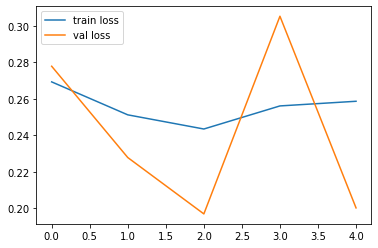

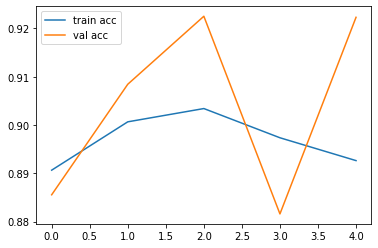

<Figure size 432x288 with 0 Axes>

In [76]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [77]:
y_pred = model.predict(test_set)

In [78]:
y_pred

array([[9.9287605e-01, 7.0705311e-03, 5.3554639e-05],
       [1.9181855e-02, 9.8081505e-01, 3.1309064e-06],
       [1.4616128e-03, 3.2380861e-01, 6.7472976e-01],
       ...,
       [3.8027818e-05, 9.9996197e-01, 3.4547917e-10],
       [9.2743295e-01, 7.0208929e-02, 2.3580901e-03],
       [9.9980897e-01, 1.7539095e-04, 1.5589501e-05]], dtype=float32)

# Run the model from here 

### For verifying the model on the test data set

In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
model=load_model('model_resnet50_b32_e5_acc92.23.h5')

In [8]:
for layer in model.layers:
    weights = layer.get_weights()

In [9]:
weights

[array([[-0.00709172,  0.0121243 ,  0.0028863 ],
        [-0.00473071, -0.02071067,  0.01924331],
        [-0.03152478, -0.11343761,  0.0951805 ],
        ...,
        [ 0.03206043, -0.04726141,  0.01594205],
        [ 0.03550573, -0.0206251 , -0.02786346],
        [ 0.00012028, -0.01283952,  0.01411662]], dtype=float32),
 array([ 0.01839969,  0.00506176, -0.04968603], dtype=float32)]

In [10]:
#img=image.load_img('output/test/COVID/COVID-1044.png',target_size=(224,224))
#img=image.load_img('output/test/Normal/Normal-10.png',target_size=(224,224))
img=image.load_img('output/test/Viral Pneumonia/Viral Pneumonia-1291.png',target_size=(224,224))#1120

In [11]:
x=image.img_to_array(img)

In [12]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [13]:
model.predict(img_data)

array([[0.0000000e+00, 1.5820437e-11, 1.0000000e+00]], dtype=float32)

In [14]:
a=np.argmax(model.predict(img_data), axis=1)
if(a==0):
    print("COVID")
elif(a==1):
    print("Normal")
else:
    print("Viral Pneumonia")

Viral Pneumonia
